<a href="https://colab.research.google.com/github/uminor/jcoins/blob/master/jcoins_counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# tensorflow のラッパーとなるライブラリ keras をインストール
!pip install -q keras

In [2]:
# いろいろインポート
import numpy as np
from numpy.random import *
import cv2
import sys
import os
import time

import tensorflow as tf
import keras
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers.core import Flatten, Dropout
from keras.optimizers import SGD

# colab メニューの「ランタイム」→「ランタイムのタイプを変更」　にて
# 「ランタイムのタイプ」＝"puthon3"
# 「ハードウェアアクセラレ」ータ＝"GPU"とした（今回は）。それの確認。
print(tf.test.gpu_device_name())

Using TensorFlow backend.


/device:GPU:0


In [3]:
# Google Drive をマウントする。
# Google Drive に、あらかじめ"Colab Work" という作業ディレクトリをつくっておく。
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


≪ディレクトリ構成≫

/content/drive/My Drive/Colab Notebooks/jcoins_counter.ipynb
 =>このノートブック。

/content/drive/My Drive/Colab Work/

jcoin_model_1yen.h5  =>1円玉を数える学習済モデル。

jcoin_model_5yen.h5   =>５円玉を数える学習済モデル。

jcoin_model_10yen.h5  =>1０円玉を数える学習済モデル。

/content/drive/My Drive/Colab Work/jcoin_images/
　=>日本円の6種類・表裏のコインの画像

/content/drive/My Drive/Colab Work/jcoin_data/
   =>コインをランダムにバラまいた状態をシミュレートした画像群。デフォルトは1000ファイル。

In [0]:
# マウントの確認。
! ls -l "/content/drive/My Drive/Colab Work/"

#  単独コインのクラス

In [0]:
class Jcoin:
    home_dir = "/content/drive/My Drive/Colab Work"
    dir = home_dir + '/jcoin_images'
    index = {}

    # 元画像ファイルを指定し、コインオブジェクトを生成
    def __init__(self, value, side, scale = 0.2):
        self.value = value
        self.side = side
        self.file_name = "{:0=3}yen_{}.png".format(value, side)
        tmp_img = cv2.imread(Jcoin.dir + '/' + self.file_name, 1)
        tmp_height, tmp_width, channels = tmp_img.shape[:3]
        self.img = cv2.resize(tmp_img, (int(tmp_height * scale), int(tmp_width * scale)))
        self.height, self.width, channels = self.img.shape[:3]
        self.radius = int(self.width / 2)
        Jcoin.index[(value, side)] = self

    def set_to_field(self, field, x_offset, y_offset, random_rotation=True):
        field_height, field_width, channels = field.shape[:3]

        if random_rotation:
            out_img = self.rotate(self.img, 360.0 * np.random.rand())

        cx, cy = self.width / 2, self.height / 2

        for iy in range(self.height):
            for ix in range(self.width):
                if random_rotation:
                    b, g, r = out_img[iy, ix]
                else:
                    b, g, r = self.img[iy, ix]
                if np.linalg.norm(np.array([ix, iy]) - np.array([cx, cy])) < r:
                    x, y = x_offset + ix - self.radius, y_offset + iy - self.radius
                    if x < field_width and y < field_height:
                        if  [255,0,0] == [b, g, r]:
                            [b, g, r] = [0, 0, 0]
                        field[y, x] = [b, g, r]

    def rotate(self, in_img, degree):
        center = tuple(np.array([self.width / 2.0,  self.height / 2.0])) ####
        size = tuple(np.array([self.width, self.height]))  ####
        rotation_matrix = cv2.getRotationMatrix2D(center, degree, 1.0)
        return cv2.warpAffine(in_img, rotation_matrix, size, flags=cv2.INTER_CUBIC)
      

#  コイン集合のクラス

In [5]:
class Jcoins:
    values_org = [1, 5, 10, 50, 100, 500] # Yen coins
    coin_len_org = len(values_org)
    
    values = values_org[0:3] # Yen coins limited
    coin_len = len(values)
    coin_range = range(coin_len)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    sides = ['F', 'B'] # Front, Back
    coins = {}

    # 最初に jcoins=Jcoins() でインスタンスを生成したときに呼ばれる。
    # 6価額(1円～500円)×両面＝12種類、のコインオブジェクトを生成し、辞書 coins に保有。
    def __init__(self):
        for val in Jcoins.values:
            for side in Jcoins.sides:
                Jcoins.coins[(val, side)] = Jcoin(val, side, 0.1)

    # 1種類のコインを返す。
    def index(self, idx):
        return Jcoins.coins[idx]

    # フィールド画像上で新しく投入しようとするコイン画像が、もともとあるコイン画像と重なるかどうか判定（True なら重ならない）
    def check_overlap(self, pos, positions, field_img):
        x, y, r = pos
        field_height, field_width, channels = field_img.shape[:3]

        if x - r < 0 or field_width < x + r or y - r < 0 or field_height < y + r :
            return False

        for p in positions:
            if  np.linalg.norm(np.array([pos[0],pos[1]]) - np.array([p[0],p[1]])) < r + p[2] :
                return False # Reject
        positions.append(pos)
        return True # Adopt

    # フィールド画像に num 個のコインをランダムに投入し、合計額を返す。
    def set_to_random_position_of_field(self, field_img, num, overlap):
        positions = []
        field_height, field_width, channels = field_img.shape[:3]
        total = 0
        count = {}
        for v in Jcoins.values_org:
            count[v] = 0

        for i in range(num):
            val = Jcoins.values[randint(len(Jcoins.values))]
            side = 'F' if 0==randint(2) else 'B' # コインの表・裏
            coin = jcoins.index((val, side))
            x, y, r = randint(field_width), randint(field_height), coin.radius
            if (overlap) or self.check_overlap([x, y, r], positions, field_img):
                coin.set_to_field(field_img, x, y, random_rotation=True)
                total = total + coin.value
                count[coin.value] = count[coin.value] + 1
                
        return total, count
    
    @classmethod
    # h5 パス名
    def h5path(cls, v):
      return '%s/jcoin_model_%syen.h5' % (Jcoin.home_dir, v)

print(Jcoins.h5path(10))


/content/drive/My Drive/Colab Work/jcoin_model_10yen.h5


In [0]:
# データ生成（訓練用、評価用）

samples = 1000
field_width, field_height = 50, 50 # コインをばらまく床のサイズ。後で読み込み時にリサイズする。
field_img = np.zeros((field_height, field_width, 3), np.uint8)

jcoins = Jcoins()
outdir = Jcoin.home_dir + "/jcoin_data"
# 生成データを増やす場合の例。多すぎてメモリがパンクする場合、ディレクトリを分ける。
#  outdir = Jcoin.home_dir + "/jcoin_data2" 

# ディレクトリの掃除
files = os.listdir(outdir)
for f in  files:
  pth = outdir + '/' + f
  os.remove(pth)

# 生成
for i in range(samples):
    field_img[:] = [0, 0, 0] # G, B, R
    total, count = jcoins.set_to_random_position_of_field(field_img, int(randint(20+20) + 1), overlap=False)
    coins = 0
    for v in Jcoins.values:
        coins = coins + count[v]
    file_name = "#{:0=6}_{:0=4}yen_{:0=2}({:0=2}_{:0=2}_{:0=2}_{:0=2}_{:0=2}_{:0=2}).png".format(i, total, coins,count[1], count[5], count[10], count[50], count[100], count[500])
    cv2.imwrite(outdir + '/' + file_name, field_img)


In [0]:
import subprocess
ret = subprocess.getoutput('ls -l sample_data')
print(ret)

In [0]:
# データ読み込み
samples = 1000 # 読み込みデータの数（生成した数以下であること）
size = 50 # 読み込み後のピクセルサイズ。メモリの事情で調整。

img_rows, img_cols = size, size
depth = 3
dim = img_rows * img_cols * depth

dir = Jcoin.home_dir + "/jcoin_data"
#dir = Jcoin.home_dir + "/jcoin_data2"

def get_each_coins_num_from_file_name(fn):
    coins_num=[]
    for j, v in enumerate(Jcoins.values):
      coins_num.append(int(f[(20 + j * 3):(20 + j * 3 + 1)]))
    return coins_num

files = os.listdir(dir)
x_train, y_train = [], []
x_test , y_test  = [], []

for i, f in enumerate(files):
    if i > samples - 1:
      break
    img = cv2.imread(dir + '/' + f, 1)
    y = get_each_coins_num_from_file_name(f)    
    value = int(f[8:12]) # 合計額
    img = cv2.resize(img, (size, size))
    height, width, channels = img.shape[:3]
    print(f, height, width, channels, value)
    x = img.reshape(img_rows, img_cols, 3).astype('float32') /255
    if i < int(samples * 0.9):
      x_train.append(x)
      y_train.append(y)
    else:
      x_test.append(x)
      y_test.append(y)
      
x_train, y_train = np.array(x_train), np.array(y_train)
x_test , y_test  = np.array(x_test) , np.array(y_test)

print(x_train.shape)

In [0]:
def init_model(indx):
  # モデル構築
  from keras.layers import Dense, Activation
  model = keras.models.Sequential()
  val = Jcoins.values[indx]
 
  # neural network model parameters
  hidden_units = 100 
  layer_depth = 1
  act =  'sigmoid' 
  bias = True

  model.add(Conv2D(size,3,input_shape=(size,size,3)))
  model.add(Activation('relu'))
  model.add(Conv2D(size,3))
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(size*2,3, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(size*2,3))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(size*16))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  # first hidden layer
  model.add(Dense(units = hidden_units, input_dim = dim, use_bias = bias))
  model.add(Activation(act))

  model.add(Dense(units = int(hidden_units / 2), use_bias = bias))
  model.add(Activation(act))
  model.add(Dense(units = int(hidden_units / 3), use_bias = bias))
  model.add(Activation(act))
  model.add(Dense(units = int(hidden_units / 4), use_bias = bias))
  model.add(Activation(act))

  # output layer
  model.add(Dense(units = 1, use_bias = bias))
  model.add(Activation('linear')) # 回帰モデルなので出力層の活性化関数で 'softmax' は使用しない。

  sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss = 'mean_squared_error', optimizer = sgd)

  # モデルの保存
  model.save(Jcoins.h5path(val))

for idx, val in enumerate(Jcoins.values):
  init_model(idx)


In [0]:
# 学習
def fit_model(indx, x, y, ep, verbo):
  val = Jcoins.values[indx]
  model = keras.models.load_model(Jcoins.h5path(val), compile=False)
  sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss = 'mean_squared_error', optimizer = sgd)

  start_fit = time.time()
  model.fit(x, y.T[indx], epochs = ep, verbose = verbo)
  elapsed = time.time() - start_fit
  print("elapsed = {:.1f} sec".format(elapsed))

  model.save(Jcoins.h5path(val))
  
for idx, val in enumerate(Jcoins.values):
  fit_model(idx, x_train, y_train, 500, 2)
#init_model(2)
#fit_model(2, x_train, y_train, 1000, 2)

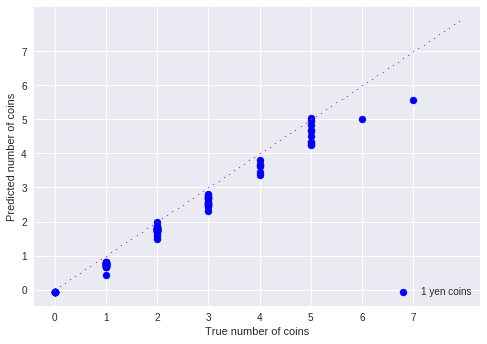

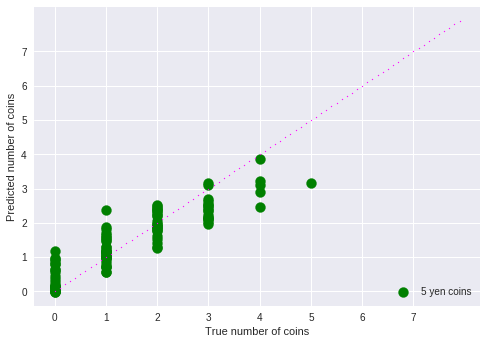

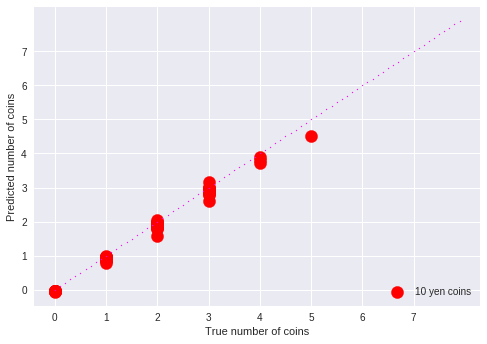

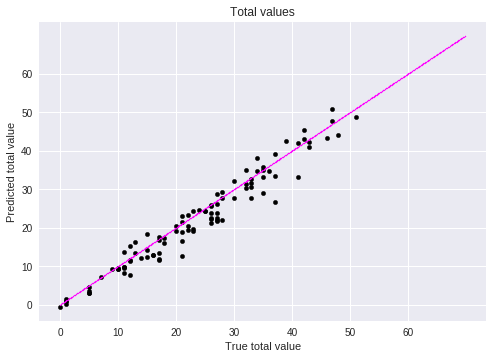

In [20]:
# 予測～プロット
import matplotlib.pyplot as plt

def plot_number_of_coin(indx, x_t, y_t):
  val = Jcoins.values[indx]
  mx = 8
  model = keras.models.load_model(Jcoins.h5path(val), compile=False)
  y_predict = model.predict(x_t)
  y_t1 = y_t.T[indx]
  y_p1 = list(map(lambda y: y[0], y_predict))
  
  plt.scatter(y_t1, y_p1, c=Jcoins.colors[indx] , marker="o", s=300-(5-indx)*50, label='%s yen coins' % val)
  std = np.array([[x/10.0,x/10.0] for x in range(mx * 10)]).T
  plt.scatter(std[0], std[1], c='Magenta' , marker="o", s=1)
  plt.legend(loc='lower right')
  plt.xlabel("True number of coins")
  plt.ylabel("Predicted number of coins")
  plt.xticks(np.arange(0, mx, 1))
  plt.yticks(np.arange(0, mx, 1))
  plt.show()
  
  return y_p1

yt_total = np.zeros(len(y_test))
yp_total = np.zeros(len(y_test))
y_test_T = y_test.T

for idx, val in enumerate(Jcoins.values):
  y_pred = plot_number_of_coin(idx, x_test, y_test)
  yt_total = yt_total + y_test_T[idx] * val
  yp_total = yp_total + np.array(y_pred) * val

mx = 70
plt.scatter(yt_total, yp_total, c='black', marker="o", s=20)
std = np.array([[x/10.0,x/10.0] for x in range(mx * 10)]).T
plt.scatter(std[0], std[1], c='Magenta' , marker="o", s=1)
plt.title('Total values')
plt.xlabel("True total value")
plt.ylabel("Predicted total value")
plt.xticks( np.arange(0, mx, 10) )
plt.yticks( np.arange(0, mx, 10) )

plt.show()



In [0]:
# モデルを可視化する場合。3つあるけどどれも同じなので、最初のをpngファイルに可視化。
from keras.utils.vis_utils import plot_model
model = keras.models.load_model(Jcoins.h5path(0), compile=False)
plot_model(model, to_file = Jcoin.home_dir + '/model.png', show_shapes=True)


In [0]:
# 推定データ表示
for yt, yp in list(zip(yt_total, yp_total)):
  print("{0:5.0f}, {1:5.2f}, {2:6.2f}, {3:6.2f} %".format(yt,round(yp, 2), round(yp-yt, 2), round((yp-yt)*100/yt, 2)) )